In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import load_data
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
from matplotlib import cm

# load data

In [4]:
sites = ['sgp','mao']
trads = ['dd','dc','udd','udc']
fh = 16

## sgp

In [5]:
#dilute_cape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/dilute_cape")
#dilute_dcape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/dilute_dcape")
#undilute_dcape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/undilute_dcape")
#undilute_cape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/undilute_cape")
sgp_lcl = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/ML/data/sgp_dilute_lcl")

sgp_dilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_dilute_dcape.txt")
sgp_dilute_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_dilute_cape.txt")
sgp_undilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_undilute_dcape.txt")
sgp_undilute_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_undilute_cape.txt")

sgp_trad_capes = {"dd":sgp_dilute_dcape, "dc":sgp_dilute_dcape, "udd":sgp_undilute_dcape, "udc":sgp_undilute_cape}

sgp_dataset = load_data.load_sgp_data("/global/homes/z/zhangtao/ML_trigger/ML/data/Arm_CF_1999_2009_hy.nc")
sgp_dataset['cape'] = sgp_undilute_dcape
sgp_dataset['lcl'] = sgp_lcl
thres = 65
sgp_dataset.rename(columns={'cape': 'ddcape'}, inplace=True)

sgp_trig_x = sgp_dataset.iloc[:,0:86]
sgp_trig_y = sgp_dataset.iloc[:,86]

sgp_trig_x_train,sgp_trig_x_test,sgp_trig_y_train,sgp_trig_y_test= train_test_split(sgp_trig_x, sgp_trig_y, test_size=0.2, random_state=20)

sgp_shape = sgp_dilute_dcape.shape
print(sgp_shape)

(22800,)


## MAO

In [6]:
#dilute_cape = np.loadtxt("../../data/goamazon/dilute_cape")
#dilute_dcape = np.loadtxt("../../data/goamazon/dilute_dcape")
#undilute_dcape = np.loadtxt("../../data/goamazon/undilute_dcape")
#undilute_cape = np.loadtxt("../../data/goamazon/undilute_cape")

mao_dilute_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_dilute_cape.txt")
mao_dilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_dilute_dcape.txt")
mao_undilute_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_undilute_cape.txt")
mao_undilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_undilute_dcape.txt")

mao_trad_capes = {"dd":mao_dilute_dcape, "dc":mao_dilute_dcape, "udd":mao_undilute_dcape, "udc":mao_undilute_cape}

mao_lcl = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/ML/data/goamazon_dilute_lcl")

mao_dataset = load_data.load_arm_hy("/global/homes/z/zhangtao/ML_trigger/ML/data/trigger_goamazon_hy.nc")
mao_dataset['cape'] = mao_undilute_dcape
mao_dataset['lcl'] = mao_lcl
mao_dataset.rename(columns={'cape': 'ddcape'}, inplace=True)

mao_trig_x = mao_dataset.iloc[:,0:86]
mao_trig_y = mao_dataset.iloc[:,86]

mao_trig_x_train,mao_trig_x_test,mao_trig_y_train,mao_trig_y_test= train_test_split(mao_trig_x, mao_trig_y, test_size=0.2, random_state=20)

mao_shape = mao_dilute_cape.shape
print(mao_shape)

(5840,)


## plot cape & rain

(22800,)
(5840,)


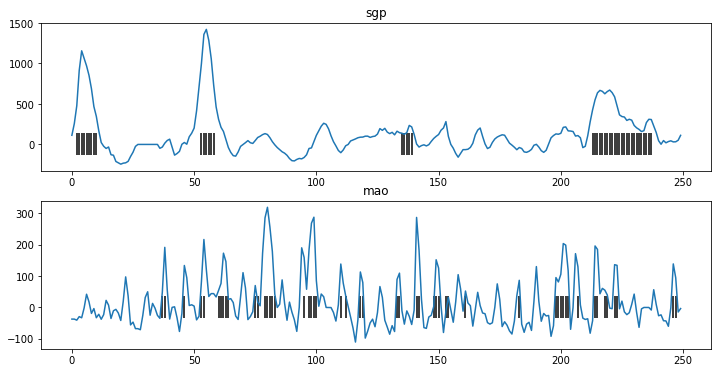

In [7]:
fig,ax = plt.subplots(2,1,figsize=(12,6))
shapes = {"sgp":sgp_shape,"mao":mao_shape}
datasets = {"sgp":sgp_dataset, "mao":mao_dataset}


for site,n in zip(sites,range(2)):
    print(shapes[site])
    shape = shapes[site][0]
    dataset = datasets[site]
    real_trigger = np.zeros(shape)
    
    
    for i in range(shape):
        if dataset.loc[i,'PRECT'] > 0.5:
            real_trigger[i] = 1
        else:
            real_trigger[i] = np.nan

    ax[n].scatter(range(250),real_trigger[:250],color='k', marker='|',s=500)
    ax[n].plot(range(250), dataset.loc[:250-1,'ddcape'])
    ax[n].set_title(site)

# traditional CAPE triggers

In [9]:
trig_x_trains = {"sgp":sgp_trig_x_train, "mao":mao_trig_x_train}
trig_y_trains = {"sgp":sgp_trig_y_train, "mao":mao_trig_y_train}
trig_x_tests = {"sgp":sgp_trig_x_test, "mao":mao_trig_x_test}
trig_y_tests = {"sgp":sgp_trig_y_test, "mao":mao_trig_y_test}
shapes = {"sgp":sgp_trig_y_test.shape, "mao":mao_trig_y_test.shape}

for site,n in zip(sites,range(2)):
    print(site)
    shape = shapes[site][0]
    cape_trigger = np.zeros(shape)
    for i in range(shape):
        if trig_x_tests[site].iloc[i,4] > thres:
            cape_trigger[i] = 1
        
    tn, fp, fn, tp = confusion_matrix(trig_y_tests[site], cape_trigger).ravel()
    f1 = f1_score(trig_y_tests[site], cape_trigger,average='macro')
    p  = precision_score(trig_y_tests[site], cape_trigger,average='macro')
    r  = recall_score(trig_y_tests[site], cape_trigger,average='macro')

    print(tp,fp,fn,tn)
    print(f1, p, r)

sgp
333 858 89 3280
0.6433731493094562 0.6265898214046728 0.790876490921044
mao
156 63 41 908
0.8479166666666667 0.8345626975763962 0.863498303596167


# XGB

sgp
341 44 81 4094
0.9150343194271345 0.9331565440547476 0.8987118579619249
mao
163 35 34 936
0.8948838847259992 0.8940903884202853 0.8956829267017623


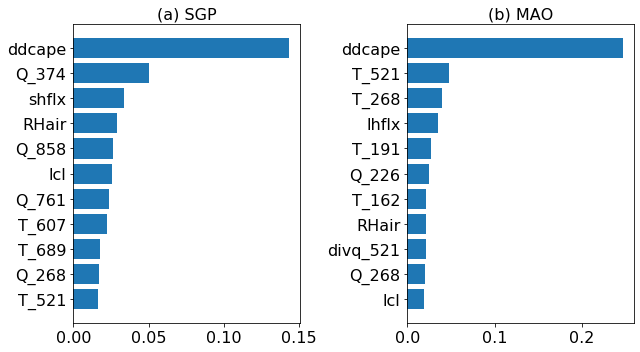

In [37]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
sites=["sgp","mao"]
fig, ax = plt.subplots(1,2,figsize=(9,5))
titles = ["(a) SGP", "(b) MAO"]

for site,n in zip(sites,range(2)):
    trig_x_train = trig_x_trains[site]
    trig_y_train = trig_y_trains[site]
    trig_x_test = trig_x_tests[site]
    trig_y_test = trig_y_tests[site]

    xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)
    xgb.fit(trig_x_train,trig_y_train)
    
    trig_y_pred = xgb.predict(trig_x_test)
    tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
    f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
    p  = precision_score(trig_y_test, trig_y_pred,average='macro')
    r  = recall_score(trig_y_test, trig_y_pred,average='macro')

    print(site)
    print(tp,fp,fn,tn)
    print(f1,p,r)


    importance = xgb.feature_importances_
    name = dataset.columns.values.tolist()[:86]
    imp = pd.DataFrame({"imp":importance, "name":name})
    imp.sort_values('imp',inplace=True,ascending=False)
    imp.reset_index(inplace=True)
    ax[n].invert_yaxis()
    ax[n].barh(imp.loc[:10,'name'],imp.loc[:10,'imp'])
    ax[n].set_title(titles[n],fontsize=fh)
    ax[n].tick_params(labelsize=fh)
    

plt.tight_layout()
plt.savefig("figs/imp.pdf")

<Figure size 864x504 with 0 Axes>

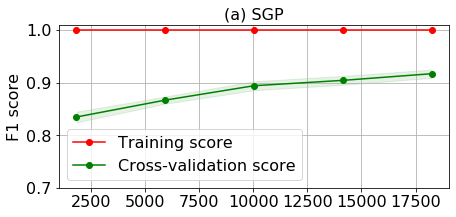

In [38]:
title = "(a) SGP"
plt.figure(figsize=(12,7))
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)
g = plot_learning_curve.plot_learning_curve(xgb,title,sgp_trig_x, sgp_trig_y,ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.xlabel("")
plt.tick_params(labelsize=fh)
plt.title(title, fontsize=fh)
plt.ylabel('F1 score', fontsize=fh)
plt.legend(fontsize=fh)
plt.legend(fontsize=fh, loc='lower left')
plt.savefig("figs/sgp_lc.pdf")

<Figure size 864x504 with 0 Axes>

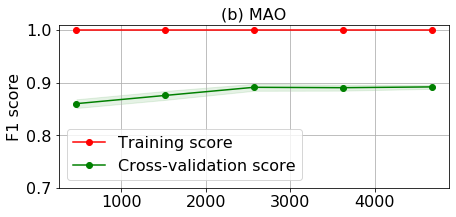

In [39]:
title = "(b) MAO"
plt.figure(figsize=(12,7))
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)
g = plot_learning_curve.plot_learning_curve(xgb,title,mao_trig_x, mao_trig_y,ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.xlabel("")
plt.tick_params(labelsize=fh)
plt.title(title, fontsize=fh)
plt.ylabel('F1 score', fontsize=fh)
plt.legend(fontsize=fh, loc='lower left')
plt.savefig("figs/mao_lc.pdf")

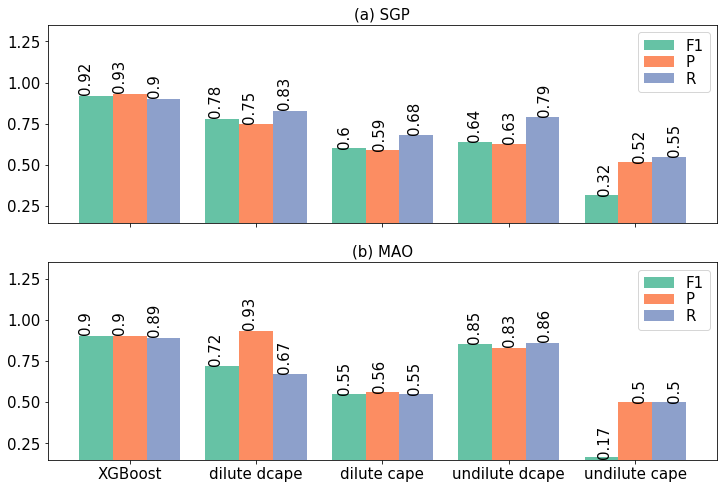

In [157]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,8))
fh = 15
sites = ["SGP", "MAO"]

palette = plt.get_cmap('Set2')

for site,n in zip(sites, range(2)):
    perf = pd.read_excel("dmpdz.xlsx", sheet_name=site, index_col='name')
    perf.iloc[:,4:].plot.bar(ax=axes[n], width = .8, color=[palette(0),palette(1),palette(2)])
    axes[n].set_title(titles[n], fontsize=fh)
    axes[n].legend(loc=1,fontsize=fh,labelspacing=0.1)
    axes[n].set_ylim(0.15,1.35)

    for p in axes[n].patches:
        axes[n].annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
    axes[n].tick_params(labelsize=fh)
    
plt.xlabel("")
plt.xticks(rotation=0)
plt.savefig("figs/perf.pdf")

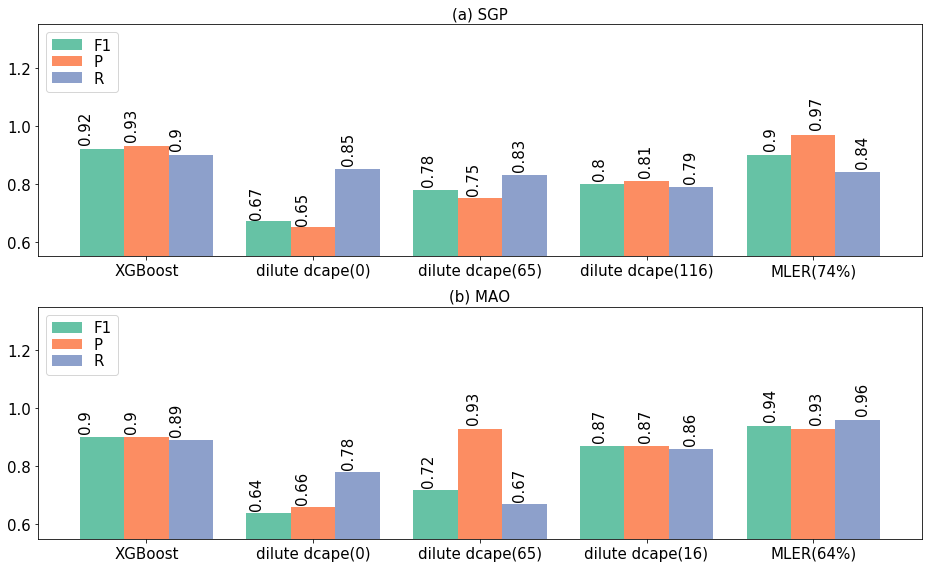

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,8))
fh = 15
sites = ["SGP_dt", "MAO_dt"]
titles = ["(a) SGP", "(b) MAO"]

palette = plt.get_cmap('Set2')

for site,n in zip(sites, range(2)):
    perf = pd.read_excel("dmpdz.xlsx", sheet_name=site, index_col='name')
    perf.iloc[:,4:].plot.bar(ax=axes[n], width = .8, color=[palette(0),palette(1),palette(2)])
    axes[n].set_title(titles[n], fontsize=fh)
    axes[n].legend(loc=2,fontsize=fh,labelspacing=0.1)
    axes[n].set_ylim(0.55,1.35)
    axes[n].tick_params(axis='x', rotation=0)
    axes[n].set_xlabel("")

    for p in axes[n].patches:
        axes[n].annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
    axes[n].tick_params(labelsize=fh)
    
plt.tight_layout()
#plt.xticks(rotation=0)
plt.savefig("figs/perf_dt.pdf")

# diurnal cycle

In [ ]:
shapes = {"sgp":sgp_trig_x.shape[0], "mao":mao_trig_x.shape[0]}
trig_xs = {"sgp":sgp_trig_x, "mao":mao_trig_x}


for site,n in zip(sites,range(2)):
    print(site)
    sl = shapes[site][0]
    train_len = int(sl * 3 / 4)
    ts_x_train = trig_xs[site].iloc[:train_len,:]
ts_y_train = trig_y.iloc[:train_len]
ts_x_test  = trig_x.iloc[train_len:,:]
ts_y_test  = trig_y.iloc[train_len:].tolist()
prect_test = dataset['PRECT'].iloc[train_len:]
hour_test  = dataset['hour'].iloc[train_len:]
day_test  = dataset['day'].iloc[train_len:]
mon_test  = dataset['mon'].iloc[train_len:]
year_test = dataset['year'].iloc[train_len:]

#print(year_test)
#print(mon_test)
#print(day_test)
#print(hour_test)
xgb.fit(ts_x_train, ts_y_train)
ts_y_pred = xgb.predict(ts_x_test)

print(ts_x_test.shape)

for i in range(ts_x_test.shape[0]):
    if ts_y_pred[i] == 0:
        ts_y_pred[i] = np.nan
    if ts_y_test[i] == 0:
        ts_y_test[i] = np.nan

# Joint

## SGP train, MAO test

In [40]:
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)

xgb.fit(sgp_trig_x,sgp_trig_y)
y_pred_amazon = xgb.predict(mao_trig_x_test)
tn, fp, fn, tp = confusion_matrix(mao_trig_y_test, y_pred_amazon).ravel()
f1 = f1_score(mao_trig_y_test, y_pred_amazon,average='macro')
P  = precision_score(mao_trig_y_test, y_pred_amazon,average='macro')
R  = recall_score(mao_trig_y_test, y_pred_amazon,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)


134 627 63 344
0.38951189433719857 0.5106464725387196 0.5172384950362544


## MAO train, SGP test

In [41]:
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)

xgb.fit(mao_trig_x,mao_trig_y)
y_pred_sgp = xgb.predict(sgp_trig_x_test)
tn, fp, fn, tp = confusion_matrix(sgp_trig_y_test, y_pred_sgp).ravel()
f1 = f1_score(sgp_trig_y_test, y_pred_sgp,average='macro')
P  = precision_score(sgp_trig_y_test, y_pred_sgp,average='macro')
R  = recall_score(sgp_trig_y_test, y_pred_sgp,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

343 931 79 3207
0.634217936727391 0.6225946907626762 0.7939041458313767


## Joint train, Joint test

In [42]:
joint = pd.concat([sgp_dataset,mao_dataset])

x_joint = joint.iloc[:,0:86]
y_joint = joint.iloc[:,86]
x_train_joint,x_test_joint,y_train_joint,y_test_joint= train_test_split(x_joint, y_joint, test_size=0.2, random_state=20)

xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)

xgb.fit(x_train_joint,y_train_joint)
y_pred_joint = xgb.predict(x_test_joint)
tn, fp, fn, tp = confusion_matrix(y_test_joint, y_pred_joint).ravel()
f1 = f1_score(y_test_joint, y_pred_joint,average='macro')
P  = precision_score(y_test_joint, y_pred_joint,average='macro')
R  = recall_score(y_test_joint, y_pred_joint,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

470 75 116 5067
0.9063120553710852 0.9200022302977093 0.8937310086379584


## Joint train, SGP test

In [43]:

x_joint_train = np.concatenate((sgp_trig_x_train, mao_trig_x_train), axis=0)
y_joint_train = np.concatenate((sgp_trig_y_train, mao_trig_y_train), axis=0)
xgb.fit(x_joint_train, y_joint_train)

y_pred_sgp = xgb.predict(sgp_trig_x_test.values)
tn, fp, fn, tp = confusion_matrix(sgp_trig_y_test, y_pred_sgp).ravel()
f1 = f1_score(sgp_trig_y_test, y_pred_sgp,average='macro')
P = precision_score(sgp_trig_y_test, y_pred_sgp,average='macro')
R = recall_score(sgp_trig_y_test, y_pred_sgp,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

345 49 77 4089
0.9152074124447467 0.9285757802466669 0.9028470378574258


## Joint train, MAO test

In [44]:
x_joint_train = np.concatenate((sgp_trig_x_train, mao_trig_x_train), axis=0)
y_joint_train = np.concatenate((sgp_trig_y_train, mao_trig_y_train), axis=0)
xgb.fit(x_joint_train, y_joint_train)

y_pred_mao = xgb.predict(mao_trig_x_test.values)
tn, fp, fn, tp = confusion_matrix(mao_trig_y_test, y_pred_mao).ravel()
f1 = f1_score(mao_trig_y_test, y_pred_mao,average='macro')
P = precision_score(mao_trig_y_test, y_pred_mao,average='macro')
R = recall_score(mao_trig_y_test, y_pred_mao,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

162 32 35 939
0.8970986002537821 0.8995586274053219 0.8946896548118796


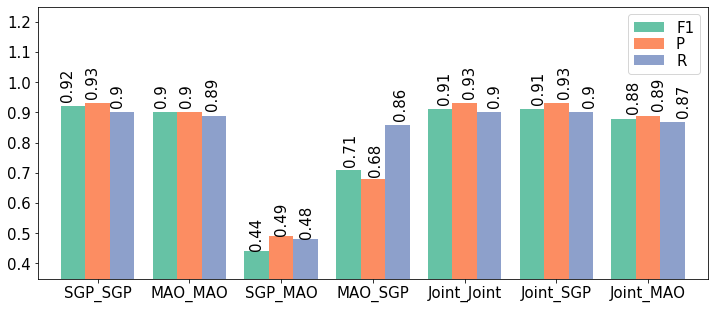

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,5))
fh = 15
perf = pd.read_excel("dmpdz.xlsx", sheet_name="joint", index_col='name')

palette = plt.get_cmap('Set2')
perf.iloc[:,4:].plot.bar(ax=axes, width = .8, color=[palette(0),palette(1),palette(2)])
axes.legend(loc=1,fontsize=fh,labelspacing=0.1)
axes.set_ylim(0.35,1.25)

for p in axes.patches:
        axes.annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
axes.tick_params(labelsize=fh)
    
plt.xlabel("")
plt.xticks(rotation=0)
plt.savefig("figs/joint.pdf")
